# Imports

In [1]:
import os
import sys
import pytz
import argparse
# import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.ioff()
from tqdm import tqdm
from geopy import distance
import datetime
import tilemapbase
from copy import deepcopy
import pickle as pkl
from PIL import Image
import skimage.measure
import math
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
os.environ['PYTHONWARNINGS']='ignore'
import hyperopt
from joblib import Parallel, delayed
import random
random.seed(42)
import scipy
import torch
from pykrige.ok import OrdinaryKriging
from pykrige.ok3d import OrdinaryKriging3D
from pykrige.uk import UniversalKriging
from sklearn.model_selection import train_test_split
from scipy.interpolate import CubicSpline
import scipy.ndimage
import scipy.stats
import scipy.optimize

# Data Loading

In [2]:
source = 'combined'
sensor = 'pm25'
res_time = '1H'
filepath_root = '/scratch/ab9738/pollution_with_sensors/'
filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

filepath_data_kai = filepath_root+'data/kaiterra/kaiterra_fieldeggid_{}_current_panel.csv'.format(res_time)
filepath_data_gov = filepath_root+'data/govdata/govdata_{}_current.csv'.format(res_time)
filepath_locs_kai = filepath_root+'data/kaiterra/kaiterra_locations.csv'
filepath_locs_gov = filepath_root+'data/govdata/govdata_locations.csv'

locs_kai = pd.read_csv(filepath_locs_kai, index_col=[0])
locs_kai['Type'] = 'Kaiterra'
locs_gov = pd.read_csv(filepath_locs_gov, index_col=[0])
locs_gov['Type'] = 'Govt'
locs = pd.merge(locs_kai, locs_gov, how='outer',\
                on=['Monitor ID', 'Latitude', 'Longitude', 'Location', 'Type'], copy=False)
data_kai = pd.read_csv(filepath_data_kai, index_col=[0,1], parse_dates=True)[sensor]
data_gov = pd.read_csv(filepath_data_gov, index_col=[0,1], parse_dates=True)[sensor]
data = pd.concat([data_kai, data_gov], axis=0, copy=False)
data.replace(0,np.nan,inplace=True)

start_dt = data.index.levels[1][0]
end_dt = data.index.levels[1][-1]

if start_dt.tzname != 'IST':
        if start_dt.tzinfo is None:
            start_dt = start_dt.tz_localize('UTC')
        start_dt = start_dt.tz_convert(pytz.FixedOffset(330))
    
if end_dt.tzname != 'IST':
    if end_dt.tzinfo is None: 
        end_dt = end_dt.tz_localize('UTC')
    end_dt = end_dt.tz_convert(pytz.FixedOffset(330))

# now, filter through the start and end dates
data.sort_index(inplace=True)
data = data.loc[(slice(None), slice(start_dt, end_dt))]

if(source=='govdata'):
    df = data_gov.unstack(level=0)
elif(source=='kaiterra'):
    df = data_kai.unstack(level=0)
else:
    df = data.unstack(level=0)
distances = pd.read_csv('/scratch/ab9738/pollution_with_sensors/data/combined_distances.csv', index_col=[0])
distances = distances.loc[df.columns, df.columns]
distances[distances == 0] = np.nan

In [3]:
sensors = df.columns
duplicates = [1,13,34,9,24,50,51]
df[sensors[duplicates]]=np.nan

# Load Wind Speeds

In [4]:
df_ws = pd.read_csv('/scratch/ab9738/pollution_with_sensors/hotspots/source_apportionment/wind_speeds.csv', parse_dates=True)
df_ws = df_ws.sort_values(['Timestamp']).reset_index(drop=True)
df_ws = df_ws.set_index(pd.DatetimeIndex(df_ws['Timestamp']))
df_ws = df_ws[['u-component', 'v-component']].groupby('Timestamp').mean()

# Load Intensity Maps

In [5]:
brick_kilns = np.load('brick_kilns_intensity_80x80.npy')
industries = np.load('industries_intensity_80x80.npy')
power_plants = np.load('power_plants_intensity_80x80.npy')
population_density = np.load('population_density_intensity_80x80.npy')
traffic_06 = np.load('traffic_06_intensity_80x80.npy')
traffic_12 = np.load('traffic_12_intensity_80x80.npy')
traffic_18 = np.load('traffic_18_intensity_80x80.npy')
traffic_00 = np.load('traffic_00_intensity_80x80.npy')

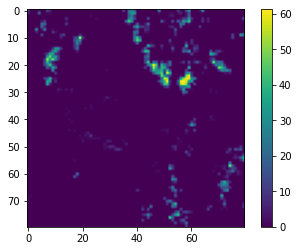

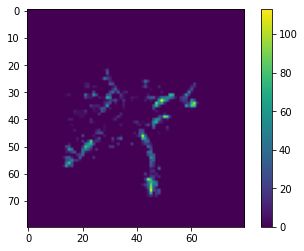

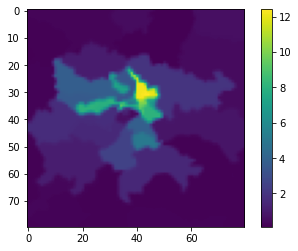

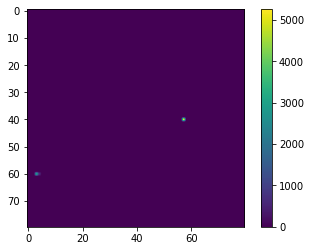

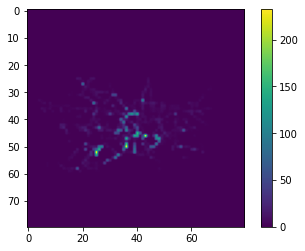

In [6]:
def heatmap2d(arr: np.ndarray):
    fig = plt.figure()
    plt.imshow(arr, cmap='viridis', origin='upper')
    plt.colorbar()
    plt.show()
    plt.close(fig)
    
    
heatmap2d(brick_kilns)
heatmap2d(industries)
heatmap2d(population_density)
heatmap2d(power_plants)
heatmap2d(traffic_18)

In [7]:
brick_kilns = torch.unsqueeze(torch.unsqueeze(torch.tensor(brick_kilns,dtype=torch.float),0),0).cuda()
industries = torch.unsqueeze(torch.unsqueeze(torch.tensor(industries,dtype=torch.float),0),0).cuda()
power_plants = torch.unsqueeze(torch.unsqueeze(torch.tensor(power_plants,dtype=torch.float),0),0).cuda()
population_density = torch.unsqueeze(torch.unsqueeze(torch.tensor(population_density,dtype=torch.float),0),0).cuda()
traffic_06 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_06,dtype=torch.float),0),0).cuda()
traffic_12 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_12,dtype=torch.float),0),0).cuda()
traffic_18 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_18,dtype=torch.float),0),0).cuda()
traffic_00 = torch.unsqueeze(torch.unsqueeze(torch.tensor(traffic_00,dtype=torch.float),0),0).cuda()

# Spline Values

In [8]:
sens = data.to_frame().reset_index()

sens['hour_of_day'] = sens['timestamp_round'].apply(lambda x: x.hour)

spline = sens.groupby(['field_egg_id', 'hour_of_day']).mean()['pm25'].reset_index()
spline_avg = sens.groupby(['hour_of_day']).mean()['pm25'].reset_index()

fields = []
times = []
pm25 = []
for i in np.unique(spline['field_egg_id']):
    s_i = spline[spline['field_egg_id']==i]
    x = s_i['hour_of_day'].values
    y = [t for t in s_i['pm25'].values]
    c1 = CubicSpline(x[:8],y[:8])
    c2 = CubicSpline(x[8:16],y[8:16])
    c3 = CubicSpline(x[16:24],y[16:24])
    ix = [k/100.0 for k in range(2400)]
    iy = list(np.concatenate((c1(ix[:800]),c2(ix[800:1600]),c3(ix[1600:2400]))))
    fields += [i]*2400
    times += ix
    pm25 += iy

spline_df = pd.DataFrame((fields, times, pm25)).transpose()

spline_df.columns = ['field_egg_id', 'time', 'pm25']

hours_in_day = np.arange(24).astype(float)

spline_df = spline_df[spline_df['time'].isin(hours_in_day)]

spline_mat = np.transpose(spline_df['pm25'].to_numpy().reshape((60,24))).astype(float)

spline_tensor = torch.tensor(spline_mat).cuda()

# Gaussian-Plume Model for Point Source

## Core Gaussian-Plume Dispersion Formula

In [9]:
# def gaussian_plume(src, dest, intensity, wind_speed, alpha, H, z=6.5, a=213, c=459.7, d=2.094, offset=100):
#     # import pdb; pdb.set_trace()
#     if(intensity>0):
#         wind_speed[1] = -wind_speed[1]
#         unit_wind_vector = wind_speed/math.sqrt(math.pow(wind_speed[0],2) + math.pow(wind_speed[1],2))
#         wind_magnitude = math.sqrt(math.pow(wind_speed[0],2) + math.pow(wind_speed[1],2))
#         if(src!=dest):
#             unit_distance_vector = np.array([dest[1]-src[1], dest[0]-src[0]])/math.sqrt(math.pow((dest[1]-src[1]),2)+math.pow((dest[0]-src[0]),2)) 
#             #reversing as lat=y-axis and long=x-axis
#             distance = math.sqrt(math.pow((dest[1]-src[1]),2)+math.pow((dest[0]-src[0]),2))*math.pow(10,5)
#             distance_vector = distance * unit_distance_vector
#             x = np.dot(distance_vector, unit_wind_vector)
#             if(x<=0):
#                 return(0.0)
#             else:
#                 x = min(x,distance)
#                 y = math.sqrt(math.pow(distance,2)-math.pow(x,2))
#                 x = max(x,offset)
#         else:
#             x = offset
#             y = 0
#         sigma_z = c*math.pow(x*0.001,d)
#         sigma_z = min(5000,sigma_z)
#         sigma_y = a*math.pow(x*0.001,0.894)
#         concentration = ((alpha*intensity)/(2*math.pi*wind_magnitude*sigma_z*sigma_y))*math.exp(-math.pow(y,2)/math.pow(2*sigma_y,2))*\
#         (math.exp(-(math.pow(z-H,2)/math.pow(2*sigma_z,2)))+math.exp(-(math.pow(z+H,2)/math.pow(2*sigma_z,2))))
#         return(concentration)
#     else:
#         return 0

## Computing concentration at a sensor because of different sources

In [10]:
# def compute_concentration(dest, ts, wind_speed, unknown, alpha, H={'traffic':0, 'brick_kilns':25, 'population':10, 'industry':30, 'power':400,\
#                                                                        'unknown':0}):
    
#     # Find the correct timestamp for the traffic sources
#     if(pd.Timestamp(ts).hour>3 and pd.Timestamp(ts).hour<9):
#         traffic_srcs = traffic_06
#     elif(pd.Timestamp(ts).hour>=9 and pd.Timestamp(ts).hour<15):
#         traffic_srcs = traffic_12
#     elif(pd.Timestamp(ts).hour>=15 and pd.Timestamp(ts).hour<21):
#         traffic_srcs = traffic_18
#     else:
#         traffic_srcs = traffic_00
    
    
#     # Initialize the different source contributions
#     contrib_brick, contrib_industry, contrib_population, contrib_traffic, contrib_power, contrib_unknown = 0.0,0.0,0.0,0.0,0.0,0.0
    
#     # Define the grid of sources under consideration
#     idx_x = int((dest[1]-76.85)/0.01)
#     idx_y = 79-int((dest[0]-28.2)/0.01)
#     src_radius = 7
        
#     for i in range(max(idx_y-src_radius,0), min(idx_y+src_radius+1,79)):
#         for j in range(max(idx_x-src_radius,0), min(idx_x+src_radius+1,79)):
#             src = (28.2+((79-j)*0.01)+0.005, 76.85+(i*0.01)+0.005)
#             contrib_brick += gaussian_plume(src, dest, brick_kilns[i,j], wind_speed, alpha['brick_kilns'], H['brick_kilns'])
#             contrib_industry += gaussian_plume(src, dest, industries[i,j], wind_speed, alpha['industry'], H['industry'])
#             contrib_population += gaussian_plume(src, dest, population_density[i,j], wind_speed, alpha['population'], H['population'])
#             contrib_traffic += gaussian_plume(src, dest, traffic_srcs[i,j], wind_speed, alpha['traffic'], H['traffic'])
#             contrib_power += gaussian_plume(src, dest, power_plants[i,j], wind_speed, alpha['power'], H['power'])
#             contrib_unknown += gaussian_plume(src, dest, unknown[i,j], wind_speed, alpha['unknown'], H['unknown'])
            
#     total_concentration = contrib_brick + contrib_industry + contrib_population + contrib_traffic + contrib_power + contrib_unknown
#     contrib = [contrib_brick, contrib_industry, contrib_population, contrib_traffic, contrib_unknown]
#     return total_concentration

# Gaussian Plume Filter

In [11]:
# def gpdm_filter(H, wind_speed, size):
#     filt = torch.zeros((size,size)).cuda()
#     dest_x, dest_y = int(size/2), int(size/2)
#     wind_speed[1] = -wind_speed[1]
#     for i in range(size):
#         for j in range(size):
#             src_x, src_y = i, j
#             unit_wind_vector = wind_speed/math.sqrt(math.pow(wind_speed[0],2) + math.pow(wind_speed[1],2))
#             wind_magnitude = math.sqrt(math.pow(wind_speed[0],2) + math.pow(wind_speed[1],2))
#             if(dest_x!=src_x and dest_y!=src_y):
#                 unit_distance_vector = np.array([dest_x-src_x, dest_y-src_y])/math.sqrt(math.pow((dest_x-src_x),2)+math.pow((dest_y-src_y),2))
#                 distance = math.sqrt(math.pow((dest_x-src_x),2)+math.pow((dest_y-src_y),2))*math.pow(10,5)
#                 distance_vector = distance * unit_distance_vector
#                 x = np.dot(distance_vector, unit_wind_vector)
#                 if(x<=0):
#                     continue
#                 else:
#                     if(math.pow(distance,2)-math.pow(x,2)<0):
#                         x = distance
#                     y = math.sqrt(math.pow(distance,2)-math.pow(x,2))
#                     x = max(x,250)
#             else:
#                 x = 250
#                 y = 0
#             sigma_z = 459.7*math.pow(x*0.001,2.094)
#             sigma_z = min(5000,sigma_z)
#             sigma_y = 213*math.pow(x*0.001,0.894)
#             filt[i,j] = (math.pow(10,9)/(2*math.pi*wind_magnitude*sigma_z*sigma_y))*math.exp(-math.pow(y,2)/math.pow(2*sigma_y,2))*\
#         (math.exp(-(math.pow(6.5-H,2)/math.pow(2*sigma_z,2)))+math.exp(-(math.pow(6.5+H,2)/math.pow(2*sigma_z,2))))
#     return(torch.unsqueeze(filt,0))

In [12]:
# def compute_filters(ts_array, H={'traffic':0, 'brick_kilns':25, 'population':10, 'industry':30, 'power':400}):
    
#     ts_filters = {'traffic':[], 'brick_kilns':[], 'population':[], 'industry':[], 'power':[]}
#     src_radius = 7
    
#     for ts in ts_array:
#         wind_speed = get_wind_speed_estimate(ts)
#         ts_filters['brick_kilns'].append(gpdm_filter(H['brick_kilns'], wind_speed, 2*src_radius+1))
#         ts_filters['industry'].append(gpdm_filter(H['industry'], wind_speed, 2*src_radius+1))
#         ts_filters['population'].append(gpdm_filter(H['population'], wind_speed, 2*src_radius+1))
#         ts_filters['traffic'].append(gpdm_filter(H['traffic'], wind_speed, 2*src_radius+1))
#         ts_filters['power'].append(gpdm_filter(H['power'], wind_speed, 2*src_radius+1))
#     for srcs in list(ts_filters.keys()):
#         ts_filters[srcs] = torch.stack(ts_filters[srcs]) 
#     return(ts_filters)

In [13]:
def cell_to_cord(i,j,size):
    return(j, size-1-i)
def cord_to_cell(x,y,size):
    return(size-1-y, x)

In [14]:
def gpdm_filter(wind_vector, size):
    filt = np.zeros((size,size))
    dest_i, dest_j = int(size/2), int(size/2)
    dest_x, dest_y = cell_to_cord(dest_i, dest_j, size)
    for i in range(size):
        for j in range(size):
            src_i, src_j = i, j
            src_x, src_y = cell_to_cord(i,j,size)
            unit_wind_vector = wind_vector/np.linalg.norm(wind_vector)
            wind_magnitude = np.linalg.norm(wind_vector)
            if(dest_x!=src_x or dest_y!=src_y):
                distance_vector = np.array([dest_x-src_x, dest_y-src_y])*math.pow(10,3)
                dist_wind = np.dot(distance_vector, unit_wind_vector)
                if(dist_wind<=0):
                    filt[src_i,src_j] = 0
                else:
                    distance_magnitude = np.linalg.norm(distance_vector)
                    dist_per = math.pow(max(math.pow(distance_magnitude,2)-math.pow(dist_wind,2),0),0.5)
                    sigma_y = 213*math.pow(dist_wind*0.001,0.894)
                    baseline_dist = 707
                    dist_wind = max(dist_wind/baseline_dist,1)
                    if(dist_per<650):
                        filt[src_i,src_j] = 1/((dist_wind**3)*wind_magnitude)
                    else:
                        filt[src_i,src_j] = 0
            else:
                filt[src_i,src_j] = 1/(wind_magnitude)        
    return(torch.squeeze(torch.tensor(filt)))

In [15]:
def get_wind_vector(ts):
    ts = np.array([ts]).astype('datetime64[ns]')[0]
    cts = min(df_ws.index, key=lambda x:abs(x-ts))
    idx = df_ws.index.to_list().index(cts)
    v1 = df_ws.iloc[idx].values
    if((cts-ts).total_seconds()>0):
        v2 = df_ws.iloc[idx-1].values
    else:
        v2 = df_ws.iloc[idx+1].values
    ws = v1+((v2-v1)*(abs((cts-ts).total_seconds())/(3600*6)))
    ws = ws*(5.0/18)
    return(ws)

In [16]:
def compute_filters(ts_array):
    src_radius = 4
    ts_filters = []
    for ts in ts_array:
        wind_vector = get_wind_vector(ts)
        ts_filters.append(gpdm_filter(wind_vector, 2*src_radius+1))
    return(ts_filters)

In [17]:
def convolve_at_sensors(sensors, ts_array, alpha, unknown, ts_filter):    
    
    concentrations_at_sensors = []
    src_radius = 4
    
    for sensor in sensors:
        dest = (locs.loc[sensor]['Latitude'], locs.loc[sensor]['Longitude'])
        idx_x = int((dest[1]-76.85)/0.01)
        idx_y = 79-int((dest[0]-28.2)/0.01)
        
        contrib_brick = torch.nn.functional.conv2d(ts_filter, \
                                                   brick_kilns[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_industry = torch.nn.functional.conv2d(ts_filter, \
                                                   industries[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_population = torch.nn.functional.conv2d(ts_filter, \
                                                   population_density[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_06 = torch.nn.functional.conv2d(ts_filter, \
                                                   traffic_06[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_00 = torch.nn.functional.conv2d(ts_filter, \
                                                   traffic_00[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_12 = torch.nn.functional.conv2d(ts_filter, \
                                                   traffic_12[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic_18 = torch.nn.functional.conv2d(ts_filter, \
                                                   traffic_18[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_power = torch.nn.functional.conv2d(ts_filter, \
                                                   power_plants[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_unknown = torch.nn.functional.conv2d(ts_filter, \
                                                   unknown[:,:,idx_x-src_radius:idx_x+src_radius+1,idx_y-src_radius:idx_y+src_radius+1],\
                                                   padding='valid')
        contrib_traffic = torch.zeros_like(contrib_traffic_06)
        for i in range(len(ts_array)):
            ts = ts_array[i]
            if(pd.Timestamp(ts).hour>3 and pd.Timestamp(ts).hour<9):
                contrib_traffic[i] = contrib_traffic_06[i]
            elif(pd.Timestamp(ts).hour>=9 and pd.Timestamp(ts).hour<15):
                contrib_traffic[i] = contrib_traffic_12[i]
            elif(pd.Timestamp(ts).hour>=15 and pd.Timestamp(ts).hour<21):
                contrib_traffic[i] = contrib_traffic_18[i]
            else:
                contrib_traffic[i] = contrib_traffic_00[i]
            
        total_concentration = alpha['brick_kilns']*contrib_brick + alpha['industry']*contrib_industry + \
        alpha['traffic']*contrib_traffic + alpha['unknown']*contrib_unknown \
        + alpha['population']*contrib_population #+ alpha['power']*contrib_power
        total_concentration = torch.squeeze(total_concentration)
        concentrations_at_sensors.append(total_concentration)
    return(concentrations_at_sensors)

In [18]:
# def get_wind_speed_estimate(ts):
#     ts = np.array([ts]).astype('datetime64[ns]')[0]
#     if(pd.Timestamp(ts).hour in [5,11,17,23]):
#         ts = ts+np.timedelta64(30,'m')
#     else:
#         ts = ts-np.timedelta64(30,'m')

#     ws = df_ws.loc[ts].values
#     ws = ws*(5.0/18)
#     return(ws)

In [19]:
# def check_timestamp(ts):
#     ts = np.array([ts]).astype('datetime64[ns]')[0]
#     if(pd.Timestamp(ts).hour in [5,11,17,23]):
#         ts = ts+np.timedelta64(30,'m')
#     else:
#         ts = ts-np.timedelta64(30,'m')

#     try:
#         ws = df_ws.loc[ts].values
#         return(True)
#     except:
#         return(False)

# ws_timestamps = df_ws.index.to_numpy()
# ts_array = np.array(list(set(data.dropna().index.get_level_values("timestamp_round").to_numpy())))
# ts_array = np.sort(ts_array)
# df_timestamps = pd.DataFrame(ts_array)
# ts_array = ts_array[df_timestamps[0].apply(lambda x: True if x.hour in [5,6,11,12,17,18,23,0] else False).to_numpy().astype(np.bool)]
# df_timestamps = pd.DataFrame(ts_array)
# ts_array = ts_array[df_timestamps[0].apply(check_timestamp).to_numpy().astype(np.bool)]

In [20]:
ts_array = np.array(list(set(data.dropna().index.get_level_values("timestamp_round").to_numpy())))
ts_array = np.sort(ts_array)

In [21]:
np.random.shuffle(ts_array)
train, test = ts_array[:int(0.8*len(ts_array))], ts_array[int(0.8*len(ts_array)):]
train_subset = random.sample(list(train), 1)

# Unkown Source Optimization 

In [22]:
train_filters = compute_filters(train)
train_filters = torch.stack(train_filters)
train_filters = torch.unsqueeze(train_filters,1)
train_filters = train_filters.cuda().float()

In [23]:
def get_mse(params):
    alpha = params['alpha']
    unknown = params['unknown']
    sensors = df.columns
    comp_values = torch.stack(convolve_at_sensors(sensors, train, alpha, unknown, train_filters),1)
    mes_values = torch.tensor(df.loc[train].to_numpy(),dtype=torch.float).cuda()
    spline_values = torch.zeros_like(comp_values)
    for i in range(len(train)):
        idx = int(train[i].hour)
        spline_values[i] = spline_tensor[idx]    
    comp_values = comp_values + spline_values
    mask = ~mes_values.isnan()
    mask = mask.long()
    comp_values = comp_values*mask
    mes_values = torch.nan_to_num(mes_values)
    mse = torch.nn.functional.mse_loss(mes_values,comp_values)
    return(mse)

def opt_fn(inp_vec):
    unknown_arr = inp_vec[:6400]
    alpha_arr = torch.abs(inp_vec[6400:])
    alpha = {'traffic':alpha_arr[0], 'brick_kilns':alpha_arr[1], 'population':alpha_arr[2],\
             'industry':alpha_arr[3], 'power':alpha_arr[4], 'unknown':alpha_arr[5]}
    unknown = torch.reshape(unknown_arr,(80,80))
    # unknown = unknown.repeat_interleave(8,0).repeat_interleave(8,1)
    unknown = torch.unsqueeze(torch.unsqueeze(unknown,0),0)
    # unknown = torch.abs(population_density+unknown)
    unknown = torch.abs(unknown)
    scale = torch.sum(brick_kilns+industries+power_plants+population_density+((traffic_06+traffic_12+traffic_18+traffic_00)*0.25))/(6400*5)
    # scale = 5000
    unknown = unknown*scale
    params = {'alpha':alpha, 'unknown':unknown}
    
    mse = get_mse(params)
    return(mse)

In [24]:
init_vector = torch.rand(6406, requires_grad=True, device='cuda')
opt = torch.optim.RMSprop([init_vector], lr=1e-1)

In [25]:
for e in range(1000):
    loss = opt_fn(init_vector)
    print(loss)
    opt.zero_grad()
    loss.backward()
    opt.step() 

tensor(7398.2271, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(8128.0693, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5629.7065, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5432.5557, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5413.4990, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5408.2026, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5404.7202, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5401.4155, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5398.5854, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5395.8052, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5393.4043, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5391.0200, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5389.0210, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5387.0864, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5385.4980, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(5383.9834, device='cuda:0', grad_fn=<MseLossBack

KeyboardInterrupt: 

In [34]:
# init_vector = torch.rand(6406,device='cuda')
# Nfeval = 1
# def callbackF(Xi):
#     global Nfeval
#     print(Nfeval)
#     print(opt_fn(Xi))
#     Nfeval += 1
# res = torchmin.minimize(opt_fn, init_guess, method='newton-cg', disp=1, max_iter=1000, callback=callbackF, options={'xtol':0,'lr':100.0})

In [26]:
init_vector

tensor([ 0.1842,  0.4516,  0.2780,  ..., -0.0054,  0.4174,  1.5345],
       device='cuda:0', requires_grad=True)

# Evaluation of Gaussian Plume Model

In [27]:
test_filters = compute_filters(test)
test_filters = torch.stack(test_filters)
test_filters = torch.unsqueeze(test_filters,1)
test_filters = test_filters.cuda().float()

In [31]:
def evaluate(inp_vec):
    unknown_arr = inp_vec[:6400]
    alpha_arr = torch.abs(inp_vec[6400:])
    alpha = {'traffic':alpha_arr[0], 'brick_kilns':alpha_arr[1], 'population':alpha_arr[2],\
             'industry':alpha_arr[3], 'power':alpha_arr[4], 'unknown':alpha_arr[5]}
    unknown = torch.reshape(unknown_arr,(80,80))
    unknown = torch.unsqueeze(torch.unsqueeze(unknown,0),0)
    # unknown = torch.abs(population_density+unknown)
    unknown = torch.abs(unknown)
    scale = torch.sum(brick_kilns+industries+power_plants+population_density+((traffic_06+traffic_12+traffic_18+traffic_00)*0.25))/(6400*5)
    unknown = unknown*scale
    
    sensors = df.columns
    comp_values = torch.stack(convolve_at_sensors(sensors, test, alpha, unknown, test_filters),1)
    mes_values = torch.tensor(df.loc[test].to_numpy(),dtype=torch.float).cuda()
    mask = ~mes_values.isnan()
    mask = mask.long()
    comp_values = comp_values*mask
    mes_values = torch.nan_to_num(mes_values)
    
    mse = torch.nn.functional.mse_loss(mes_values,comp_values)
    abs_err = torch.abs(mes_values-comp_values)
    percent_abs_err = torch.div(abs_err,mes_values)*100
    percent_abs_err = torch.nan_to_num(percent_abs_err, posinf=0)
    mape = torch.mean(percent_abs_err)
    return(mse, mape)

In [32]:
rmse, mape = evaluate(init_vector)

In [33]:
print(rmse, mape)

tensor(11217.4053, device='cuda:0', grad_fn=<MseLossBackward0>) tensor(55.6430, device='cuda:0', grad_fn=<MeanBackward0>)


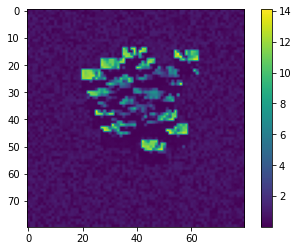

In [34]:
unknown_arr = init_vector[:6400]
unknown = torch.reshape(unknown_arr,(80,80))
# unknown = unknown.repeat_interleave(8,0).repeat_interleave(8,1)
unknown = torch.unsqueeze(torch.unsqueeze(unknown,0),0)
# unknown = torch.abs(population_density+unknown)
unknown = torch.abs(unknown)
scale = torch.sum(brick_kilns+industries+power_plants+population_density+((traffic_06+traffic_12+traffic_18+traffic_00)*0.25))/(6400*5)
# scale = 5000
unknown = unknown*scale
unknown = torch.squeeze(unknown)
unknown = unknown.cpu().detach().numpy()
heatmap2d(unknown)

# Mapping and Source Apportionment of Hotspots

In [56]:
def full_convolutions_at_ts(idx, alpha, unknown, ts_filter):

    contrib_brick = torch.nn.functional.conv2d(brick_kilns, torch.unsqueeze(ts_filter[idx],0), padding='same')
    contrib_industry = torch.nn.functional.conv2d(industries, torch.unsqueeze(ts_filter[idx],0), padding='same')
    contrib_population = torch.nn.functional.conv2d(population_density, torch.unsqueeze(ts_filter[idx],0), padding='same')
    contrib_traffic_06 = torch.nn.functional.conv2d(traffic_06, torch.unsqueeze(ts_filter[idx],0), padding='same')
    contrib_traffic_00 = torch.nn.functional.conv2d(traffic_00, torch.unsqueeze(ts_filter[idx],0), padding='same')
    contrib_traffic_12 = torch.nn.functional.conv2d(traffic_12, torch.unsqueeze(ts_filter[idx],0), padding='same')
    contrib_traffic_18 = torch.nn.functional.conv2d(traffic_18, torch.unsqueeze(ts_filter[idx],0), padding='same')
    contrib_power = torch.nn.functional.conv2d(power_plants, torch.unsqueeze(ts_filter[idx],0), padding='same')
    contrib_unknown = torch.nn.functional.conv2d(unknown, torch.unsqueeze(ts_filter[idx],0), padding='same')
    contrib_traffic = torch.zeros_like(contrib_traffic_06)
    ts = ts_array[idx]
    if(pd.Timestamp(ts).hour>3 and pd.Timestamp(ts).hour<9):
        contrib_traffic = contrib_traffic_06
    elif(pd.Timestamp(ts).hour>=9 and pd.Timestamp(ts).hour<15):
        contrib_traffic = contrib_traffic_12
    elif(pd.Timestamp(ts).hour>=15 and pd.Timestamp(ts).hour<21):
        contrib_traffic = contrib_traffic_18
    else:
        contrib_traffic = contrib_traffic_00

    total_concentration = alpha['brick_kilns']*contrib_brick + alpha['industry']*contrib_industry + \
    alpha['population']*contrib_population + alpha['traffic']*contrib_traffic + alpha['unknown']*contrib_unknown #+ alpha['power']*contrib_power
    return(total_concentration)

In [57]:
unknown_arr = init_vector[:6400]
alpha_arr = torch.abs(init_vector[6400:])
alpha = {'traffic':alpha_arr[0], 'brick_kilns':alpha_arr[1], 'population':alpha_arr[2],\
         'industry':alpha_arr[3], 'power':alpha_arr[4], 'unknown':alpha_arr[5]}
# alpha= {'traffic':1, 'brick_kilns':1, 'population':1,\
#          'industry':1, 'power':1, 'unknown':1}
unknown = torch.reshape(unknown_arr,(80,80))
# unknown = unknown.repeat_interleave(8,0).repeat_interleave(8,1)
unknown = torch.unsqueeze(torch.unsqueeze(unknown,0),0)
# unknown = torch.abs(population_density+unknown)
unknown = torch.abs(unknown)
scale = torch.sum(brick_kilns+industries+power_plants+population_density+((traffic_06+traffic_12+traffic_18+traffic_00)*0.25))/(6400*5)
# scale = 5000
unknown = unknown*scale
map_array = full_convolutions_at_ts(30,alpha,unknown,train_filters)

In [58]:
map_array = torch.squeeze(map_array).cpu().detach().numpy()

In [59]:
map_array

array([[1.0076393 , 0.74112487, 0.0624111 , ..., 0.12203255, 0.12278604,
        0.12223037],
       [0.5218568 , 0.53071356, 0.10099606, ..., 0.1342175 , 0.132077  ,
        0.13277648],
       [0.03623308, 0.12746039, 0.09929619, ..., 0.13610105, 0.13405895,
        0.1331745 ],
       ...,
       [0.02197929, 0.04390726, 0.0496362 , ..., 0.04766524, 0.04689992,
        0.04780005],
       [0.02323336, 0.04297213, 0.04481598, ..., 0.04558123, 0.04541995,
        0.04698231],
       [0.02259108, 0.04208   , 0.04324681, ..., 0.04577874, 0.04769468,
        0.04910361]], dtype=float32)

In [63]:
fig, ax = plt.subplots(figsize=(12,12), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.imshow(map_array[19:59,16:56], cmap='viridis', interpolation='nearest')
plt.axis('off')
# plt.colorbar()
# plt.show()
plt.savefig('heatmap.png',bbox_inches='tight')
plt.close(fig)

In [61]:
region_lat_b, region_lat_t, region_long_l, region_long_r = 28.39, 28.78, 77.01, 77.40
# region_lat_b, region_lat_t, region_long_l, region_long_r = 28.20, 29.00, 76.85, 77.65
subset_locs = locs[(locs['Latitude']<region_lat_t) & (locs['Latitude']>region_lat_b) &\
                   (locs['Longitude']<region_long_r) & (locs['Longitude']>region_long_l)]

lat_lims = region_lat_b, region_lat_t
lon_lims = region_long_l, region_long_r
lat_center, lon_center = (region_lat_b + region_lat_t)/2, (region_long_l + region_long_r)/2

extent = tilemapbase.Extent.from_lonlat(region_long_l, region_long_r, region_lat_b, region_lat_t)
extent_proj = extent.to_project_3857

# use openstreetmap (OSM)
t = tilemapbase.tiles.Stamen_Toner_Background

colordict = {'Kaiterra':'r', 'Govt':'b'}

plt.rc('font', size=20)

fig, ax = plt.subplots(figsize=(12,12), dpi=200)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plotter = tilemapbase.Plotter(extent, t, width=600)
plotter.plot(ax, t)

for row in subset_locs.itertuples():
    x, y = tilemapbase.project(row.Longitude, row.Latitude)
    if row.Type == 'Kaiterra':
        obj1 = ax.scatter(x, y, marker='.', color='r', s=10, label='Our sensors')
    else:
        obj2 = ax.scatter(x, y, marker='.', color='b', s=10, label='CPCB/DPCC/IMD')
    ax.text(x, y, row.Index, fontsize=6)

# ax.legend((obj1, obj2), (obj1.get_label(), obj2.get_label()), loc='lower right', ncol=2)
fig.savefig('base_map.png',bbox_inches='tight')
# plt.show()
plt.close(fig)

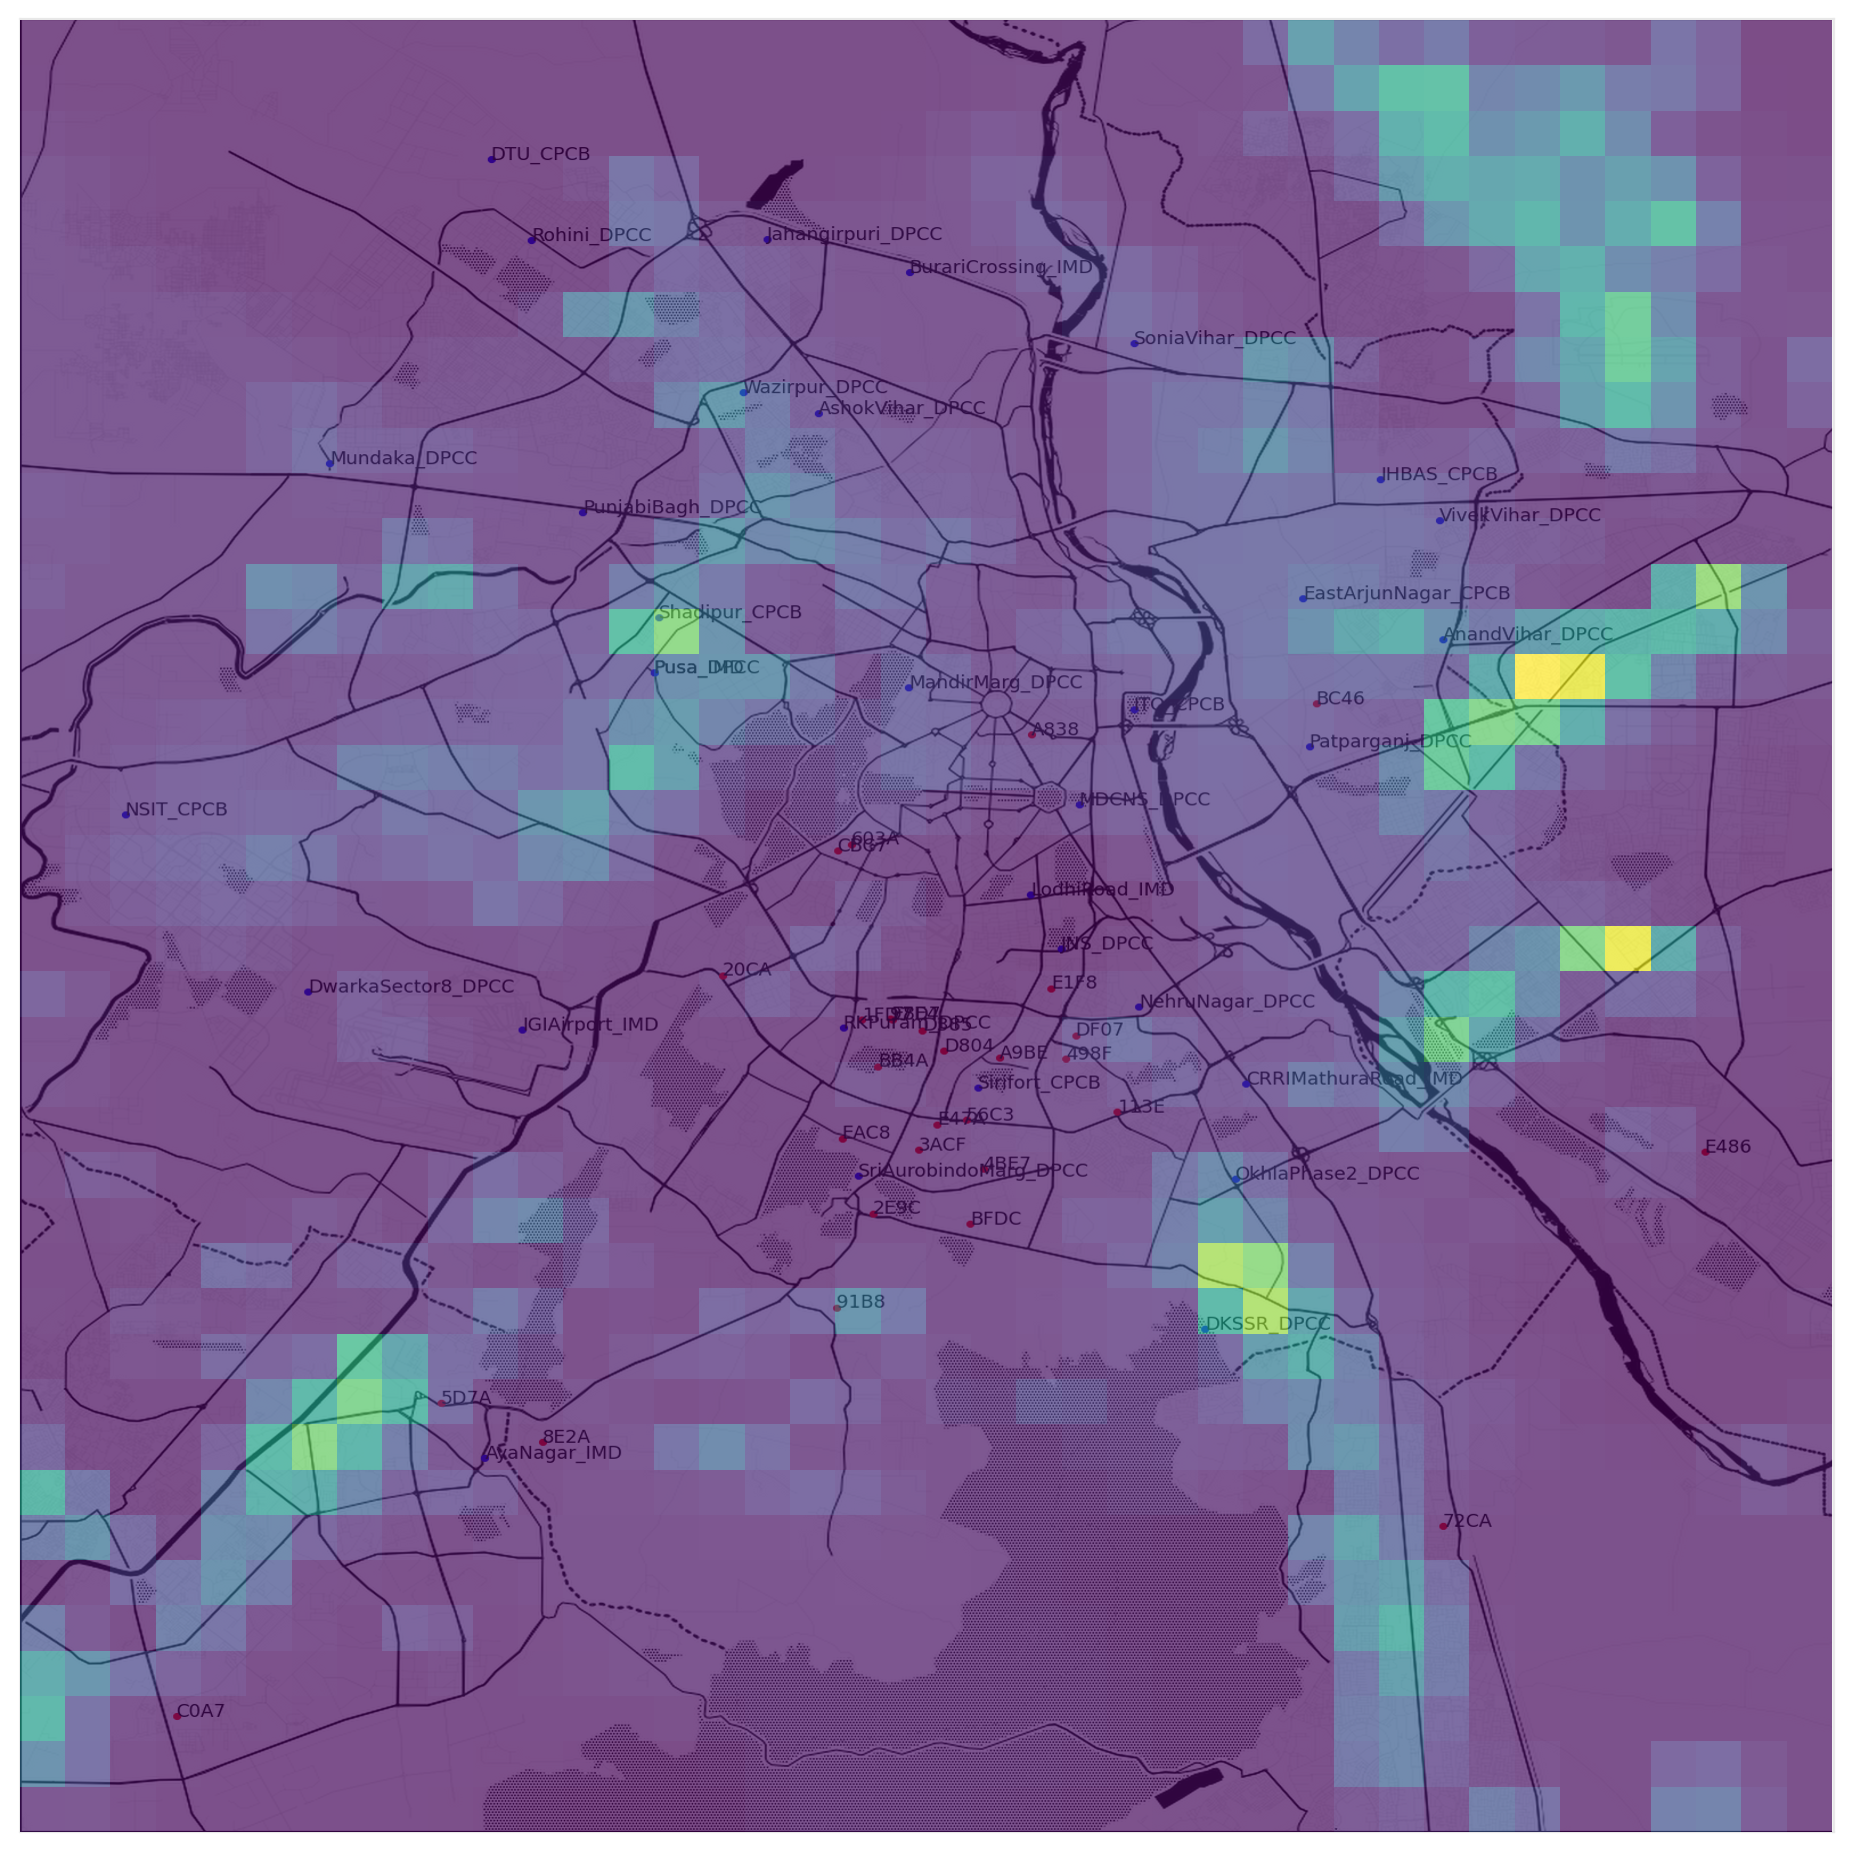

In [65]:
base_map = Image.open('./base_map.png')
heatmap = Image.open('./heatmap.png')
base_map = Image.fromarray(np.asarray(base_map)[:-10,12:-3,:])
heatmap = Image.fromarray(np.asarray(heatmap))
base_map = base_map.resize(heatmap.size)
new_map = Image.blend(base_map, heatmap, alpha=0.7)
new_map